# 307.1. Active Galactic Nuclei Photometry and Light Curves

<div>
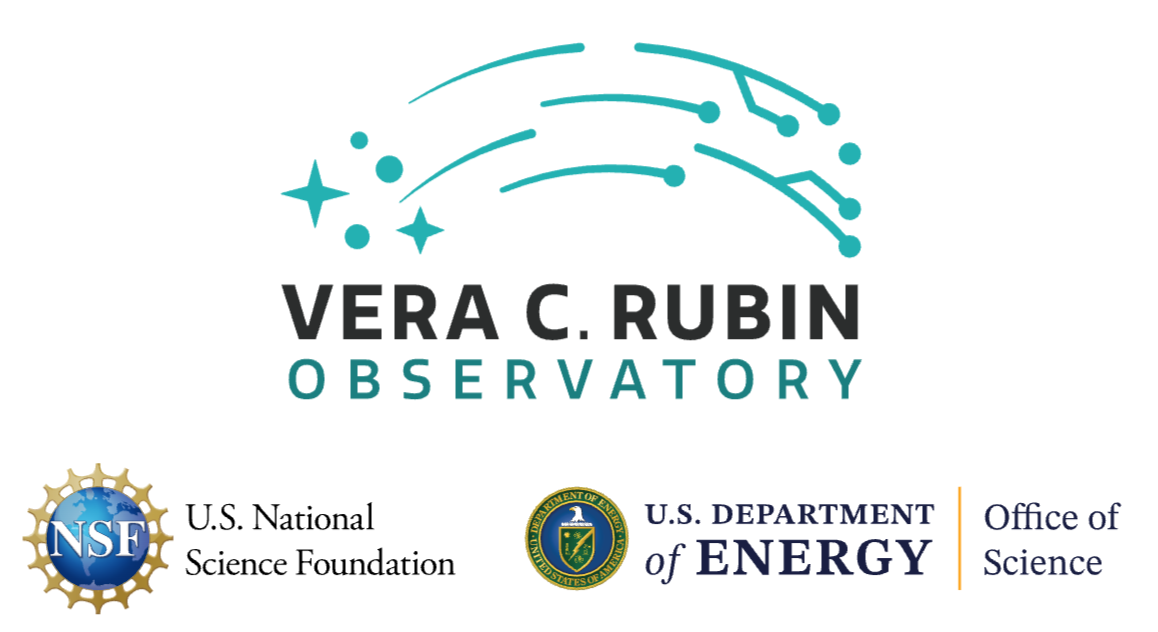
</div>

For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: DP1 <br>
Container Size: Large <br>
LSST Science Pipelines version: r29.2.0 <br>
Last verified to run: 2025-09-02 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>

**Learning objective:** Retrieve photometry and plot a light curve for an Active Galactic Nucleus from DP1.

**LSST data products:** `ForcedSourceOnDiaObject`, `DiaObject`, `Visit`, `Object`

**Packages:** `lsst.rsp`, `lsst.utils.plotting`

**Credit:** Originally developed by the Rubin Community Science team.
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:** Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook demonstrates how to obtain and plot light curves and photometry, using an Active Galactic Nucleus (AGN) captured in the Data Preview 1 (DP1). A previously identified quasar, <a href="https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=VII/294&-c=53.1125547%20-27.6848222&-c.rs=1"> CDFS J03324-2741B</a> (ra, dec = 53.1125, -27.6848) was covered by LSSTComCam observations of the Extended Chandra Deep Field South (ECDFS; center ra, dec = 53.2, -28.1). This particular object was identified in the DP1 by crossmatching AGN catalogs to the `DiaObject` catalog. It was selected for this demonstration by the number of detections in difference images.

<div style="width: 520px; margin: auto; overflow: hidden;">
  <div style="float: left;">
    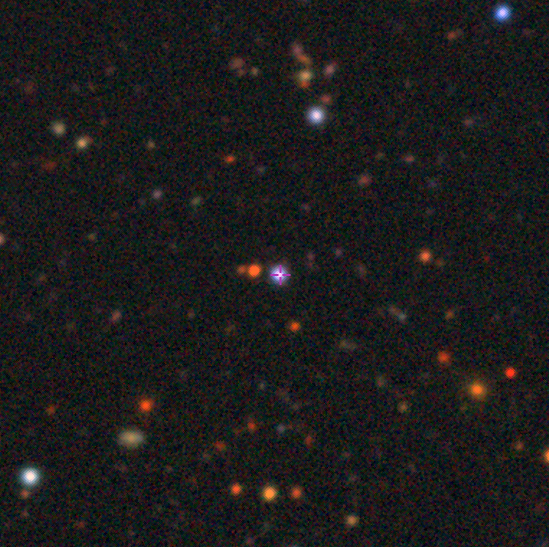
  </div>
  <div style="float: right;">
    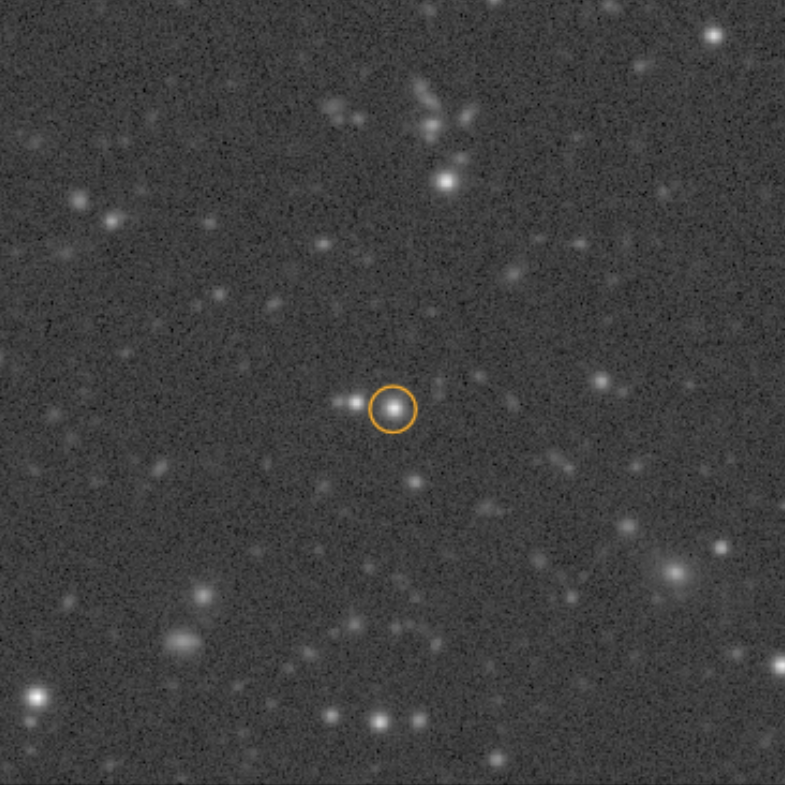
  </div>
</div>

 > **Figure 1:** The left panel shows a <a href="http://aladin.unistra.fr/AladinLite/?target=03%2032%2027.013-27%2041%205.36&fov=0.05&survey=CDS%2FP%2FDES-DR2%2FColorIRG"> color image </a> from the Dark Energy Survey (DES) DR1 at the coordinates of the AGN. The right panel shows an $i$-band coadded image from the DP1 at the location of the AGN. The coadded image cutout was obtained following the 100-level tutorial on small image cutouts.

Related tutorials: The 200-level tutorials on difference image analysis (DIA) catalogs.

### 1.1 Import packages

Import `numpy`, a fundamental package for scientific computing with arrays in Python
(<a href="https://numpy.org">numpy.org</a>), and `matplotlib`, a comprehensive library for data visualization
(<a href="https://matplotlib.org/">matplotlib.org</a>; 
<a href="https://matplotlib.org/stable/gallery/index.html">matplotlib gallery</a>). Also import the `units` module from <a href="https://www.astropy.org/">Astropy</a>, which will be used to convert fluxes to magnitudes. 

From the `lsst` package, import the module for accessing the Table Access Protocol (TAP) service, and some plotting utilities.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from lsst.rsp import get_tap_service

from lsst.utils.plotting import (get_multiband_plot_colors,
                                 get_multiband_plot_symbols)

### 1.2 Define parameters and functions

Get an instance of the TAP service, and assert that it exists.

In [ ]:
service = get_tap_service("tap")
assert service is not None

Define colors, symbols, and linestyles to represent the six LSST filters, $ugrizy$.

In [ ]:
filter_names = ['u', 'g', 'r', 'i', 'z', 'y']
filter_colors = get_multiband_plot_colors()
filter_symbols = get_multiband_plot_symbols()

## 2. Retrieve light curve data 

Obtain light curve data from the `ForcedSourceOnDiaObject` table, which contains forced PSF photometry for *all* difference images as well as direct images (`visit_images`). The relevant table columns for plotting light curves are:

* `diaObjectId`: Unique DiaObject identifier
* `psfDiffFlux`: Forced PSF photometry on difference images at the DiaObject position
* `psfFlux`: Forced PSF photometry on `visit_images` at the DiaObject position
* `band`: Filter associated with flux measurement
* `visit`: Identifier of the visit where the forced photometry was measured (used for table JOIN on `Visit` table)

The date information `expMidptMJD`, which is mid-point time for the visit in MJD, can be obtained from the `Visit` table.

### 2.1 Look up diaObjectId from coordinates

Define the coordinates of an AGN captured in DP1. Use the coordinates of the quasar <a href="https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=VII/294&-c=53.1125547%20-27.6848222&-c.rs=1"> CDFS J03324-2741B</a>.

In [ ]:
ra_agn = 53.1125547
dec_agn = -27.6848222

Search at this position in the `DiaObject` table to retrieve the `diaObjectId` of the corresponding object. Use a spatial query with a 0.50 arcsec (0.00014 degrees) radius around the defined ra and dec.

In [ ]:
query = "SELECT ra, dec, diaObjectId "\
        "FROM dp1.DiaObject "\
        "WHERE CONTAINS(POINT('ICRS', ra, dec), "\
        "CIRCLE('ICRS'," + str(ra_agn) + ", "\
        + str(dec_agn) + ", 0.00014)) = 1 "
print(query)

In [ ]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

Fetch the results of the TAP search in table form and print the unique entries for `diaObjectId` in the output table.

In [ ]:
assert job.phase == 'COMPLETED'
dia_object = job.fetch_result().to_table()
print(np.unique(dia_object['diaObjectId']))

### 2.2. Search based on diaObjectId

Provide this `diaObjectId` as a constraint to a TAP query to obtain the time series from `ForcedSourceOnDiaObject`. The use of an ID in this manner is always the recommended way to access data from a ForcedSource table.

In [ ]:
DiaObjID = dia_object['diaObjectId'][0]

In [ ]:
query = "SELECT fsodo.coord_ra, fsodo.coord_dec, "\
        "fsodo.diaObjectId, fsodo.visit, fsodo.band, "\
        "fsodo.psfDiffFlux, fsodo.psfDiffFluxErr, "\
        "fsodo.psfFlux as psfFlux, fsodo.psfFluxErr, "\
        "vis.expMidptMJD "\
        "FROM dp1.ForcedSourceOnDiaObject as fsodo "\
        "JOIN dp1.Visit as vis ON vis.visit = fsodo.visit "\
        "WHERE fsodo.diaObjectId = "+str(DiaObjID)
print(query)

Run the query and store the results in an Astropy table.

In [ ]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()
assert job.phase == 'COMPLETED'

In [ ]:
dia_fsource = job.fetch_result().to_table()

Uncomment to display the table results.

In [ ]:
# dia_fsource

## 3. Plot the light curve

### 3.1 Plot flux vs. time 

Plot the forced PSF photometry on the difference images and direct images at the location of the AGN.

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
fig.subplots_adjust(wspace=0, hspace=0)

for j in range(len(filter_names)):
    band = filter_names[j]
    fx = (dia_fsource['band'] == band)
    ax[0].plot(dia_fsource['expMidptMJD'][fx], dia_fsource['psfDiffFlux'][fx],
               filter_symbols[band], ms=10, mew=2, mec=filter_colors[band],
               alpha=0.5, color='none', label=f'{band}')
    ax[1].plot(dia_fsource['expMidptMJD'][fx], dia_fsource['psfFlux'][fx],
               filter_symbols[band], ms=10, mew=2, mec=filter_colors[band],
               alpha=0.5, color='none', label=f'{band}')

ax[0].legend(ncols=2, loc='lower right')
ax[0].set_ylabel('Difference Image PSF Flux (nJy)')
ax[0].minorticks_on()

ax[1].set_ylabel('Direct Image PSF Flux (nJy)')
ax[1].set_xlabel('MJD')
ax[1].minorticks_on()

plt.show()

> **Figure 2:** Forced PSF photometry at the location of a known AGN from the `ForcedSourceOnDiaObject` table. The top panel shows the light curves for the six LSST filters $ugrizy$, using the difference image PSF flux vs. time. The bottom panel shows the light curve using the direct image PSF flux vs. time.

Note that the difference image PSF fluxes include both positive and negative values, as variable sources can appear brighter or fainter than in the template image used to perform the image subtraction. Forced photometry on the difference images may be preferable due to potential contributions from the host-galaxy in the direct images.

### 3.2 Plot magnitude vs. time

The direct image PSF fluxes are all positive and can safely be converted to magnitudes. In the case of PSF photometry from difference images, it is not recommended to try to convert to magnitudes.

Convert the direct image PSF fluxes to magnitudes.

In [ ]:
dia_fsource['psfMag'] = dia_fsource['psfFlux'].to(u.ABmag).value

Plot the light curve using PSF magnitudes.

In [ ]:
fig, ax = plt.subplots(1, figsize=(6, 4))
ax.invert_yaxis()

for j in range(len(filter_names)):
    band = filter_names[j]
    fx = (dia_fsource['band'] == band)
    ax.plot(dia_fsource['expMidptMJD'][fx], dia_fsource['psfMag'][fx],
            filter_symbols[band], ms=10, mew=2, mec=filter_colors[band],
            alpha=0.5, color='none', label=f'{band}')
ax.set_ylabel('Direct Image PSF Mag')
ax.set_xlabel('MJD')
ax.set_ylim(20.3, 19.1)
ax.legend(ncols=2, loc='lower right')
ax.minorticks_on()
plt.show()

> **Figure 3:** The light curve is shown as PSF magnitude vs. time, with the PSF flux from direct images converted to magnitudes.

## 4. Retrieve PSF photometry from the `Object` table

The previous sections focused on forced photometry at the position of a `DiaObject` detected in difference imaging. As persistent sources, AGN will also be identified as an `Object` in the coadded images, and light curves can be retrieved from the `ForcedSource` table. For further exploration, this section demonstrates how to retrieve photometric data from the `Object` table and use it to construct a spectral energy distribution (SED). The relevant table columns for this notebook are:

* `ObjectId`: Unique Object identifier
* `[filter]_psfFlux`: Flux derived from linear least-squares fit of PSF model. Forced photometry.

The object catalog also has pre-computed AB magnitudes.

### 4.1 Query the `Object` table

Create a spatial query for a 0.50 arcsec (0.00014 degrees) radius around the defined ra and dec. Retrieve the PSF fluxes in each filter.

In [ ]:
query = "SELECT objectId, coord_ra, coord_dec, "\
        "u_psfFlux, g_psfFlux, r_psfFlux, "\
        "i_psfFlux, z_psfFlux , y_psfFlux, "\
        "u_psfFluxErr, g_psfFluxErr, r_psfFluxErr, "\
        "i_psfFluxErr, z_psfFluxErr, y_psfFluxErr "\
        "FROM dp1.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str(ra_agn) + ", "\
        + str(dec_agn) + ", 0.00014)) = 1 "

Run the query and store the results in an Astropy table.

In [ ]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()
assert job.phase == 'COMPLETED'

In [ ]:
obj = job.fetch_result().to_table()
# obj

### 4.2 Plot the SED

Define the <a href="https://rubinobservatory.org/for-scientists/rubin-101/instruments"> effective wavelength </a> for the LSST filters.

In [ ]:
filter_wavelengths = {'u': 372.4, 'g': 480.7, 'r': 622.1,
                      'i': 755.9, 'z': 868.0, 'y': 975.3}  # nanometers

The photometry measurements in the catalogs are flux densities in units of nano-Jansky [nJy], where 1 Jy = $10^{-23}$ ergs/s/cm^2/Hz. To plot the SED, calculate $\nu F_{\nu}$ from the flux density ($F_{\nu}$) given in nJy, and plot it against the observed frequency ($\nu$) for each filter.

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
fig.subplots_adjust(wspace=0, hspace=0)

c = 3e17  # speed of light in nanometers/s

for j in range(len(filter_names)):
    band = filter_names[j]
    nu = c/filter_wavelengths[band]
    fnu = obj[f'{band}_psfFlux']  # PSF flux in nJy
    nufnu = fnu*nu*(10**-9)
    ax.plot(np.log10(nu), np.log10(nufnu),
            filter_symbols[band], ms=10, mew=2, mec=filter_colors[band],
            alpha=0.5, color='none', label=f'{band}')

ax.set_ylabel(r'$\log_{10} \nu F_\nu$ (Jy Hz)')
ax.set_xlabel(r'$\log_{10} \nu $ (Hz)')
ax.set_ylim(10.20, 10.60)
ax.set_xlim(14.35, 15.05)
ax.legend(ncols=2, loc='lower right')
ax.minorticks_on()

> **Figure 4:** The observed SED for the object at the location of the AGN, which is brightest in the $g$-band. The SED is shown in the observed frame with no corrections for the redshift of the AGN (z = 0.734).